In [1]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def load_data():
    from sklearn.datasets import load_iris
    return load_iris().data, load_iris().target

In [3]:
X, y = load_data()
print(X.shape, y.shape)

(150, 4) (150,)


In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Логистическая регрессия

#### Вывод

Идея: Имея линейную регрессию мы можем преобразовать область выходных значений так, чтобы ограничить выход линейной регрессией в области $[0, 1]$

Имеем следующее уравнение линейной регрессии:
$$y = \left<x, w \right>, \space x \in \mathbb{R}^{n \times d}, \space y \in \mathbb{R}$$

Нам необходимо свести его к следующей форме:
$$y_c \Leftarrow \left<x, w \right>, \space x \in \mathbb{R}^{n \times d}, \space y_c \in \{0, 1\}$$

Далее для удобства представим, что $\left<x, w \right>$ генерируют вероятность

$$P \Leftarrow \left<x, w \right>, \space x \in \mathbb{R}^{n \times d}, \space P \in [0, 1]$$

Все еще нельзя заменить $\Leftarrow$ на равенство. Поэтому представим выход модели как шансы - отношения вероятностей.

$$\frac{P}{1-P} \Leftarrow \left<x, w \right>, \space x \in \mathbb{R}^{n \times d},\space \frac{P}{1-P} \in (0, +\infty)$$

Дальше самым логичным ходом будет представить результат как логарифм от шансов. Область значений логарифма нам отлично подходит. И тогда мы сможем заменить $\Leftarrow$ на равенство.

$$\log \left(\frac{P}{1-P}\right) = \left<x, w \right>, \space x \in \mathbb{R}^{n \times d},\space \log \left(\frac{P}{1-P}\right) \in (-\infty, +\infty)$$
Видим, что область определения и область значений нашей функции сошлись.
$$y = \left<x, w \right>, \space x \in \mathbb{R}^{n \times d}, \space y \in \mathbb{R}$$
В результате мы представили область значений так, что мы сможем получить нашу вероятность принадлежности одному из классов.

Отсюда выводится следующее понятие:

***Логит (logit, log odds)*** - логарифм взятый от шанса, который позволяет линейной комбинации признаков быть представленной как вероятность события.

Далее из полученной формулы выведем нашу вероятность.

Сначала проэкспонируем обе части равенства, чтобы избавиться от логарифма. 
$$\log \left(\frac{P}{1-P}\right) = \left<x, w \right> \rightarrow \frac{P}{1-P} = e^{\left<x, w \right>} $$
$$ P =  e^{\left<x, w \right>} + pe^{\left<x, w \right>} \rightarrow e^{\left<x, w \right>} = P + pe^{\left<x, w \right>} \rightarrow e^{\left<x, w \right>} = P \left( 1 + e^{\left<x, w \right>} \right)$$
$$P = \frac{e^{\left<x, w \right>}}{1 + e^{\left<x, w \right>}} \rightarrow P = \frac{e^{\left<x, w \right>}}{1 + e^{\left<x, w \right>}} \frac{e^{-\left<x, w \right>}}{e^{-\left<x, w \right>}} \rightarrow P = \frac{1}{1 + e^{-\left<x, w \right>}}$$

Полученная функция называется сигмойдой. И обозначается как $\sigma(z) = \frac{1}{1 + e^{-z}}$

Таким образом:
$$P = \sigma(\left< w, x\right>)$$

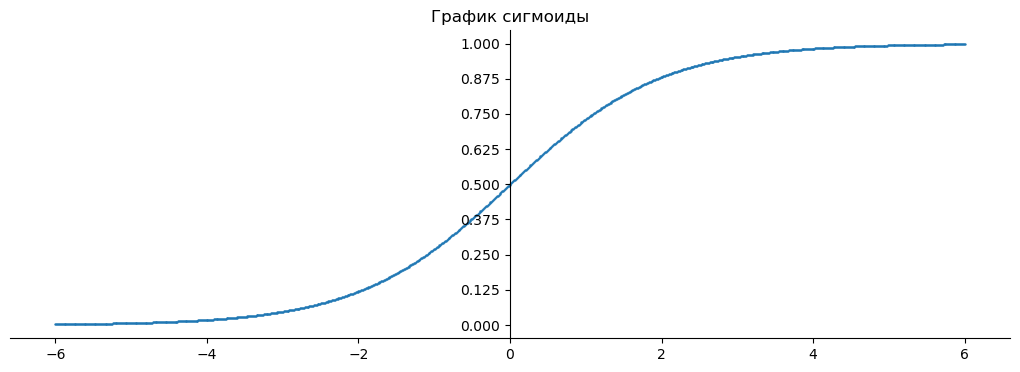

In [5]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.set_title('График сигмоиды')
ax.scatter(np.linspace(-6, 6, 1000), 1 / (1 + np.exp(-1 * np.linspace(-6, 6, 1000))), s=0.5)

ax.spines['left'].set_position('zero')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.yticks(np.linspace(0, 1, 9))

plt.subplots_adjust(left=4, right=5)

Нам необходимо оценить то, как хорошо наша модель определяет класс объекта. Т. к. задача логистической регрессии определяется для бинарной классификации, то оценить то, насколько результаты наших предсказаний правдивы, поможет функция правдоподобия. 

При составлении логистической регрессии для оценки модели **мы составляем функцию потерь, которая потом оптимизируется для получения наилучшего результата**. 

Вывод функции потерь начинается с того, что **отправной точкой для рассчета функции потерь мы можем использовать функцию правдоподобия посчитанную для распределения Бернулли**. Распределение Бернулли здесь подходит из-за того, что логистическая регрессия используется для бинарной классификации, а распределение Бернулли описывает вероятности двух противоположных событий, что можно интерпритировать как наши два класса {0, 1}. 

**Функцию правдоподобия мы составляем потому, что она позволяет оценить то, как наш вектор весов w составлен правильно в соответствии с реальными прецедентами (данными)**. Это можно описать следующим предложением: "Насколько правдоподобно то, что данные представленные в выборке тренировочных таргетов являются правильными, если мы используем параметр w"

Функция правдоподобия для распределения Бернулли:
$$L(y, p) = \prod_{i=1}^{n} p^{y_i} (1 - p)^{1 - y_i}$$

Для гладкости функции и легкости оптимизации возьмем log от нашей функции правдободобия. Это справедливо, т. к. логарифм - монотонная функция.

$$\log(L(y, p)) = \sum_i^{n} y_i \log(p) + (1-y_i) \log(1 - p)$$

Нам необходимо максимизировать правдоподобие, но раз уж принято, что мы все подряд минимизируем, то сведем задачу к минимизации отрицательного правдоподобия:

$ L(X, w, y) = - \sum_i^{n} y_i \log(p) + (1 - y_i) \log(1 - p) \rightarrow \min_w $ 

Далее заменим вероятность на выведенную ранее формулу:

$$L(X, w, y) = - \sum_i^{n} y_i \log(\sigma(\left< x, w\right>)) + (1 - y_i) \log(1 - \left< x, w\right>) \rightarrow \min_w$$

Для удобства совершим следующее преобразование. Можно заметить, что:
$$\sigma(-x) = \frac{1}{1 + e^x} = \frac{1}{1 + e^x} \frac{e^{-x}}{e^{-x}} = \frac{e^{-x}}{e^{-x} + 1} = 1 - \frac{1}{1 + e^{-x}} = 1 - \sigma(x)$$
$$\downarrow$$
$$L(X, w, y) = - \sum_i^{n} y_i \log(\sigma(\left< x, w\right>)) + (1 - y_i) \log(-\left< x, w\right>) \rightarrow \min_w$$

Далее нам необходимо продифференцировать нашу полученную функцию потерь по w.

- Дописать дифф

#### В результате всех действий получаем:
$$p = \sigma(\left<x, w \right>) = \frac{1}{1 + e^{-\left<x, w \right>}}$$
$$L(x, w, y) = \sum_i^n y_i\log(\sigma(\left<x_i, w \right>)) + (1 - y_i)\log(\sigma(-\left<x_i, w \right>))$$
$$\nabla L(x, w, y) = -\sum_i^n x_i(y_i - \sigma(\left<x_i, w\right>)$$

In [6]:
y_train

array([2, 0, 2, 1, 0, 2, 1, 0, 0, 1, 0, 1, 2, 2, 2, 0, 0, 0, 2, 2, 2, 1,
       0, 1, 0, 0, 2, 0, 0, 0, 0, 2, 1, 2, 2, 1, 2, 0, 0, 2, 2, 0, 1, 1,
       0, 1, 2, 0, 1, 0, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 0, 1, 1, 0, 2, 0,
       1, 0, 0, 1, 0, 0, 1, 2, 2, 0, 1, 2, 2, 0, 0, 0, 0, 1, 0, 2, 1, 2,
       0, 2, 2, 1, 1, 2, 0, 1, 1, 1, 1, 0, 1, 1, 2, 1, 0, 1, 0, 0, 2, 2,
       1, 0, 2, 0, 1, 2, 1, 1, 2, 2])

In [7]:
y_train_setosa = np.where(y_train > 0, 0, 1)
y_train_setosa

array([0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0])

In [8]:
y_test_setosa = np.where(y_test > 0, 0, 1)
y_test_setosa

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 0, 1, 0])

In [9]:
X_train.shape

(120, 4)

In [10]:
def sigm(x: np.ndarray) -> np.ndarray:
    return 1 / (1 + np.exp(-x))

In [11]:
w = np.random.normal(size=X_train.shape[1])

In [12]:
for i in range(1000):    
    loss = -(y_train_setosa * np.log(sigm(X_train @ w)) + (1 - y_train_setosa) * np.log(sigm(- X_train @ w))).sum()
    if i % 100 == 0:
        print(loss)
    grad = -(X_train * (y_train_setosa - sigm(X_train @ w))[:, np.newaxis]).sum(axis=0)
    w -= 0.01 * grad
loss = -(y_train_setosa * np.log(sigm(X_train @ w)) + (1 - y_train_setosa) * np.log(sigm(- X_train @ w))).sum()
print(loss)

771.5307386385805
0.6517304068606774
0.3817498599105361
0.27396317087099464
0.21522773739729545
0.17801625913114838
0.1522208387732231
0.13323183207163353
0.11863860086206458
0.1070545871913463
0.09762416031973756


In [13]:
pred = np.where(sigm(X_test @ w) > 0.7, 1, 0)
pred

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 0, 1, 0])

In [14]:
y_test_setosa

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 0, 1, 0])

In [15]:
from sklearn.metrics import f1_score

f1_score(y_test_setosa, pred)

1.0

In [ ]:
class LogisticRegression():
    '''
    Selfmade class for implementing simple logistic regression
    (without regularization)
    Optimization metod - stochastic gradient desctent with two variations of steps
    Multiclass classification is emplemented with all-vs-all approach
    '''
    def __init__():
        pass
        
    def __